Semantic Segmentation 
============

In this exercise you are going to work on a computer vision task called semantic segmentation. In comparison to image classification the goal is not to classify an entire image but each of its pixels separately. This implies that the  output of the network is not a single scalar but a segmentation with the same shape as the input image. Think about why you should rather use convolutional than fully-connected layers for this task!

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

# 1. Preparation

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load and Visualize Data

#### MSRC-v2 Segmentation Dataset

The MSRC v2 dataset is an extension of the MSRC v1 dataset from Microsoft Research in Cambridge. It contains *591* images and *23* object classes with accurate pixel-wise labeled images. 



The image ids are stored in the txt file `train.txt`, `val.txt`, `test.txt`. The dataloader will read the image id in the txt file and fetch the corresponding input and target images from the image folder. 
<img src='images/input_target.png'/>



As you can see in `exercise_code/data/segmentation_dataset.py`, each segmentation label has its corresponding RGB value stored in the `SEG_LABELS_LIST`. The label `void` means `unlabeled`, and it is displayed as black `"rgb_values": [0, 0, 0]` in the target image. The target image pixels will be labeled based on its color using `SEG_LABELS_LIST`.

```python
                SEG_LABELS_LIST = [
                {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
                {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
                {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
                {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
                {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
                {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
                {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
                ...]    
```

<div class="alert alert-block alert-warning">
    <h3>Note: The label <code>void</code></h3>
    <p>Pixels with the label <code>void</code> should neither be considered in your loss nor in the accuracy of your segmentation. See implementation for details.</p>
</div>

In [2]:
download_url = 'http://filecremers3.informatik.tu-muenchen.de/~dl4cv/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

If you want to implement data augmentation methods, make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data/segmentation_dataset.py`. Furthermore, you can check the original label description in `datasets/segmentation/segmentation_data/info.html`.

For now, let's look at a few samples of our training set:

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


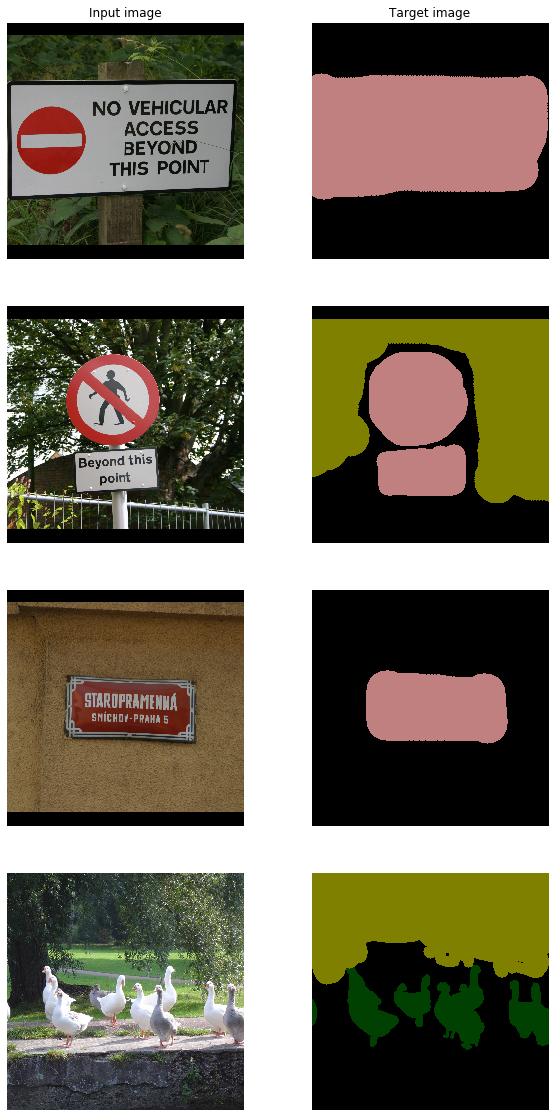

In [3]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

We can already see that the dataset is quite small in comparison to our previous datasets, e.g., for CIFAR10 we had ten thousands of images while we only have 276 training images in this case. In addition, the task is much more difficult than a "simple 10 class classification", as we have to assign a label to each pixel! What's more, the images are much bigger as we are now considering images of size 240x240 instead of 32x32. 

That means that you shouldn't expect our networks to perform very well, so don't be too disappointed.

# 2. Semantic Segmentation 

## Dummy Model

In `exercise_code/networks/segmentation_nn.py` we define a naive `DummySegmentationModel`, which always predicts the scores of segmentation labels of the first image. Let's try it on a few images and visualize the outputs using the `visualizer` we provide. The `visualizer` takes in the model and dataset, and visualizes the first four (Input, Target, Prediction) pairs. 

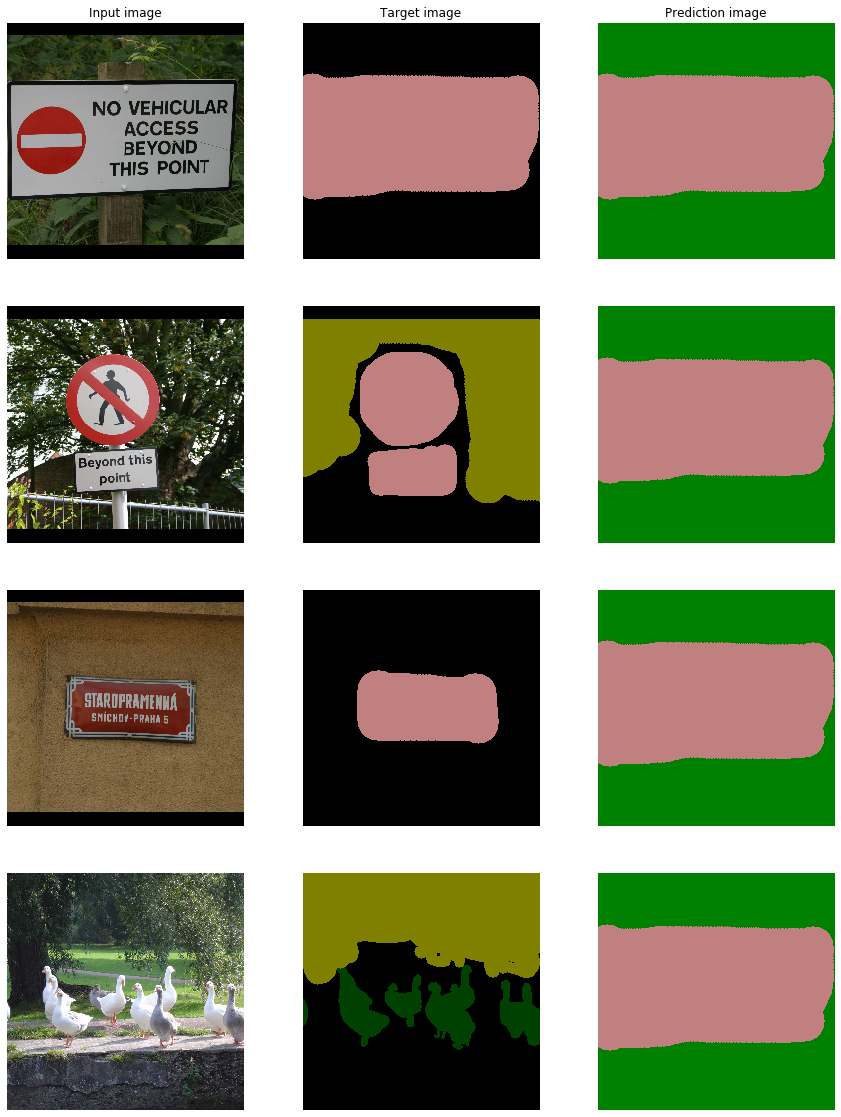

In [4]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

If you want, you can use the visualizer function in your training scenario to print out your model predictions on a regular basis.

## Loss and Metrics
The loss function for the task of image segmentation is a pixel-wise cross entropy loss. This loss examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. 
<img src='images/loss_img.png' width=80% height=80%/>
source: https://www.jeremyjordan.me/semantic-segmentation/

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) in our solvers. However, In order to ignore the `unlabeled` pixels for the computation of our loss, we have to use a customized version of the loss for the initialization of our segmentation solver. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.


In [5]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0))
    print(losses)

tensor(2.2072)
tensor(2.9416)
tensor(2.2076)
tensor(3.2083)


<div class="alert alert-warning">
    <h3>Note: Non-zero loss for the first sample</h3> 
    <p>The output of our dummy model is one-hot-coded tensor. Since there is <b>softmax</b> function in the <b>nn.CrossEntropyLoss</b> function, the loss is:  
    $$loss(x, class) = - \log \left( \frac{\exp(x[class])}{\Sigma_j \exp (x[j])} \right) = −x[class]+\log \left( \Sigma_j \exp(x[j]) \right)$$
     and the loss will not be zero.    </p>
<p>i.e. for $x=[0, 0, 0, 1],class=3$,$\quad$ the loss: 
$loss(x,class) = -1 +\log(\exp(0)+\exp(0)+\exp(0)+\exp(1)) = 0.7437$ </p>
</div>

To obtain an evaluation accuracy, we can simply compute the average per pixel accuracy of our network for a given image. We will use the following function:

In [6]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        
        
        
        
        targets_mask = targets >= 0
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
print(evaluate_model(dummy_model, test_loader))

0.14179702232915609


You will see reasonably high numbers as your accuracy when you do the training later. The reason behind that is the fact that most output pixels are of a single class and the network can just overfit to common classes such as "grass".

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement your network architecture in <code>exercise_code/networks/segmentation_nn.py</code>. In this task, you will use pytorch to setup your model.
    </p>
</div>

To compensate for the dimension reduction of a typical convolution layer, you should probably include either a single `nn.Upsample` layer, use a combination of upsampling layers as well as convolutions or even transposed convolutions near the end of your network to get back to the target image shape.

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`. Input dimension is (N, C, H, W) and output dimension is (N, num_classes, H, W)
* Have less than 5 million parameters
* Have a model size of less than 50MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict `hparams`.

<div class="alert alert-warning">
    <h3>Note: Transfer learning</h3>
    <p>In this exercise, we encourage you to do transfer learning as we learned in exercise 8, since this will boost your model performance and save training time. You can import pretrained models from torchvision in your model and use its feature extractor (e.g. <code>alexnet.features</code>) to get the image feature. Feel free to choose more advanced pretrained model like ResNet, MobileNet for your architecture design.</p>       
</div>

See [here](https://pytorch.org/vision/stable/models.html) for more info of the torchvison pretrained models.


In [7]:
import torchvision.models as models
pretrained_model=models.alexnet(pretrained=True).features

In [8]:
pretrained_model(train_data[0][0].unsqueeze(0)).shape

torch.Size([1, 256, 6, 6])

In [9]:
hparams = {
    "pretrained_model":pretrained_model,
    "learning_rate":1.3e-3,
    "batch_size":20
    
    
    # TODO: if you have any model arguments/hparams, define them here and read them from this dict inside SegmentationNN class
}

In [10]:
print(hparams)

{'pretrained_model': Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
), 'learning_rate': 0.0013, 'batch_size': 20}


In [11]:
model = SegmentationNN(hparams = hparams)
test_seg_nn(model)

ParamCountTest passed. Your model has 3.006 mio. params.
FileSizeTest passed. Your model is 21.9 MB large
All tests passed for your model. Tests passed: 2/2


## Step 2: Train your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.
    </p>
</div>

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchvision.models as models


train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt') #from exercise_8.exercise_code.models import Classifier

train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams["batch_size"], shuffle=False, num_workers=0)
    

model = SegmentationNN(hparams)




########################################################################
# TODO - Train Your Model                                              #
########################################################################
class Solver(object):
    default_adam_args = {"lr": 1e-4,
                         "betas": (0.9, 0.999),
                         "eps": 1e-8,
                         "weight_decay": 0.0}

    def __init__(self, optim=torch.optim.Adam, optim_args={},
                 loss_func=torch.nn.CrossEntropyLoss()):
        optim_args_merged = self.default_adam_args.copy()
        optim_args_merged.update(optim_args)
        self.optim_args = optim_args_merged
        self.optim = optim
        self.loss_func = loss_func

        self._reset_histories()

    def _reset_histories(self):
        """
        Resets train and val histories for the accuracy and the loss.
        """
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.val_loss_history = []
        self.train_epoch_acc_history = []
        self.val_epoch_acc_history = []

    def train(self, model, train_loader, val_loader, num_epochs=10, log_nth=0):
        """
        Train a given model with the provided data.
        Inputs:
        - model: model object initialized from a torch.nn.Module
        - train_loader: train data in torch.utils.data.DataLoader
        - val_loader: val data in torch.utils.data.DataLoader
        - num_epochs: total number of training epochs
        - log_nth: log training accuracy and loss every nth iteration
        """
        optim = self.optim(model.parameters(), **self.optim_args)
        self._reset_histories()
        iter_per_epoch = len(train_loader)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        print('START TRAIN.')
        #######################################################################
        # TODO:                                                               #
        # Write your own personal training method for our solver. In each     #
        # epoch iter_per_epoch shuffled training batches are processed. The   #
        # loss for *each batch* is stored in self.train_loss_history. Every   #
        # log_nth iteration the loss is logged. After one epoch the training  #
        # *accuracy of the last mini batch* is logged and stored in           #
        # self.train_acc_history. We *validate at the end of each epoch*, log #
        # the result and store *the accuracy of the entire validation set* in #
        # self.val_acc_history.                                               #
        #                                                                     #
        # Your logging could like something like:                             #
        #   ...                                                               #
        #   [Iteration 700/4800] TRAIN loss: 1.452                            #
        #   [Iteration 800/4800] TRAIN loss: 1.409                            #
        #   [Iteration 900/4800] TRAIN loss: 1.374                            #
        #   [Epoch 1/5] TRAIN acc/loss: 0.560/1.374                           #
        #   [Epoch 1/5] VAL   acc/loss: 0.539/1.310                           #
        #   ...                                                               #
        ##################\
        for epoch in range(1, num_epochs+1):
            # Train for one epoch
            train_out = None
            train_targets = None
            for iter, (train_inputs, train_targets) in enumerate(train_loader, 1):
                train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)
                
                optim.zero_grad()                                 # Clear gradients
                train_out = model(train_inputs)                   # Get predictions
                loss = loss_func(train_out, train_targets)   # Calculate loss
                loss.backward()                                   # Backpropagation
                optim.step()                                      # Optimize parameters based on backpropagation
                self.train_loss_history.append(loss.item())       # Store loss for each batch

                # Log nth iteration
                if iter % log_nth == 0:
                    print("[Iteration {}/{}] TRAIN loss: {}".format(iter, iter_per_epoch, loss.item()))
            
           
            _, train_preds = torch.max(train_out, 1) # torch.max returns (max, max_indices)
            targets_mask = train_targets >= 0
            acc = np.mean((train_preds == train_targets)[targets_mask].data.cpu().numpy())
            self.train_acc_history.append(acc)

            # Validate after training for one epoch
            model.eval()
            for (val_inputs, val_targets) in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_out = model(val_inputs)
                # Calculate & store loss
                loss = self.loss_func(val_out, val_targets)
                self.val_loss_history.append(loss.item())
                # Calculate & store accuracy
                _, val_preds = torch.max(val_out, 1) # torch.max returns (max, max_indices)
                targets_mask = val_targets >= 0
                acc = np.mean((val_preds == val_targets)[targets_mask].data.cpu().numpy())
                self.val_acc_history.append(acc)
            model.train()

            # Log the results at the end of the epoch
            train_loss = np.mean(self.train_loss_history)
            train_acc = self.train_acc_history[-1]
            val_loss = np.mean(self.val_loss_history)
            val_acc = np.mean(self.val_acc_history)
            print("[Epoch {}/{}] TRAIN acc/loss: {}/{}".format(epoch, num_epochs, train_acc, train_loss))
            print("[Epoch {}/{}] VAL   acc/loss: {}/{}".format(epoch, num_epochs, val_acc, val_loss))
            self.train_epoch_acc_history.append(train_acc)
            self.val_epoch_acc_history.append(val_acc)

solver = Solver(optim_args={"lr":1e-4,"weight_decay":0.001},loss_func=torch.nn.CrossEntropyLoss(ignore_index=-1,reduction="mean"))
solver.train(model,train_loader,val_loader, log_nth=5,num_epochs=20)
#######################################################################
#                           END OF YOUR CODE                          #
#######################################################################

START TRAIN.


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[Iteration 5/14] TRAIN loss: 3.0720958709716797
[Iteration 10/14] TRAIN loss: 2.826742649078369
[Epoch 1/20] TRAIN acc/loss: 0.08521288039140845/2.9546673468181064
[Epoch 1/20] VAL   acc/loss: 0.24313751932365602/2.610907713572184
[Iteration 5/14] TRAIN loss: 2.72432017326355
[Iteration 10/14] TRAIN loss: 1.788183331489563
[Epoch 2/20] TRAIN acc/loss: 0.3648322287379854/2.605309362922396
[Epoch 2/20] VAL   acc/loss: 0.330663643827728/2.35293847322464
[Iteration 5/14] TRAIN loss: 2.106113910675049
[Iteration 10/14] TRAIN loss: 1.3628177642822266
[Epoch 3/20] TRAIN acc/loss: 0.5583955029667927/2.2985125609806607
[Epoch 3/20] VAL   acc/loss: 0.3901805710411346/2.1510668330722384
[Iteration 5/14] TRAIN loss: 1.6674262285232544
[Iteration 10/14] TRAIN loss: 1.1020249128341675
[Epoch 4/20] TRAIN acc/loss: 0.6465474166348589/2.0525033133370534
[Epoch 4/20] VAL   acc/loss: 0.4414180935386829/1.9748447636763256
[Iteration 5/14] TRAIN loss: 1.314613699913025
[Iteration 10/14] TRAIN loss: 0.92583

# 3. Test your Model

In [13]:
test(evaluate_model(model, test_loader))

Validation-Accuracy: 76.7504084483976%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


# 4. Visualization

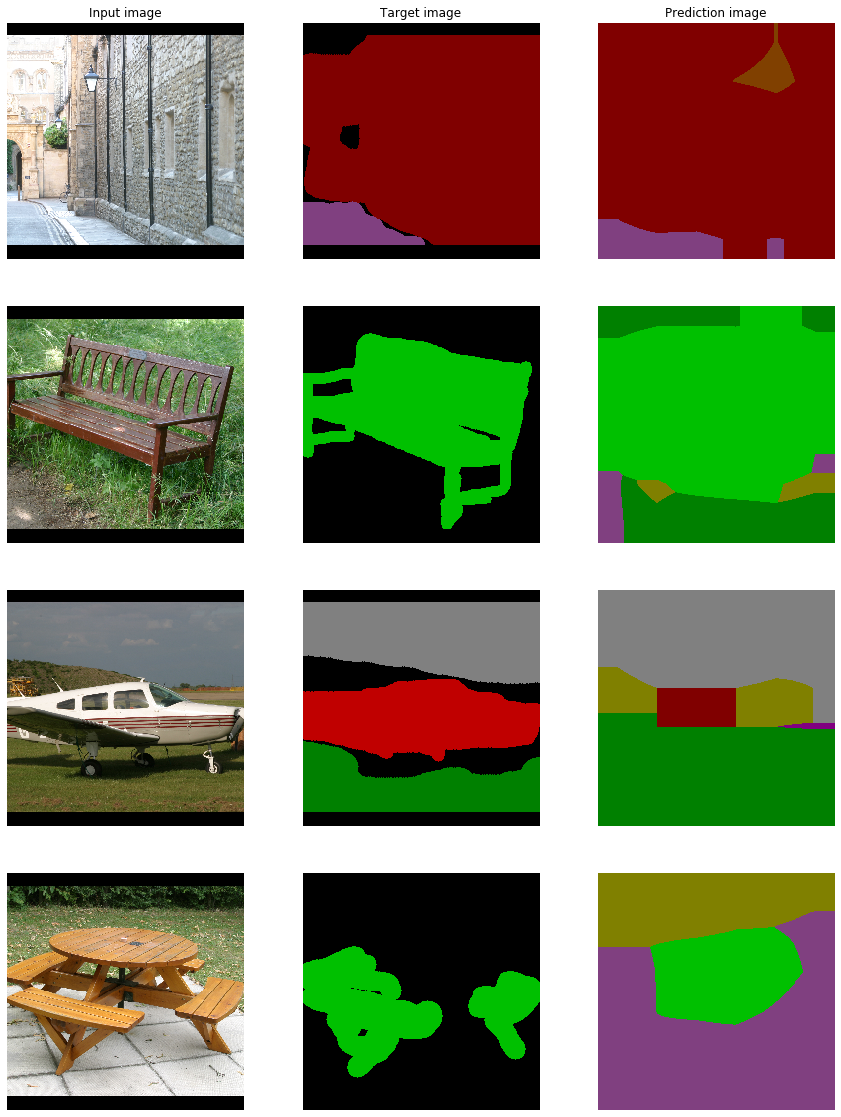

In [14]:
visualizer(model, test_data)

## Save the Model for Submission

When you are satisfied with your training, save the model for [submission](https://i2dl.vc.in.tum.de/submission/). In order to be eligible for the bonus points you have to achieve an accuracy above __60%__.

In [15]:
os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")
checkSize(path = "./models/segmentation_nn.model")

Great! Your model size is less than 50 MB and will be accepted :)


True

In [16]:
from exercise_code.util.submit import submit_exercise

submit_exercise('exercise10')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1_segmentation_nn.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1_segmentation_nn.ipynb
Zipping successful! Zip is stored under: /Users/meiqiliu/Downloads/exercise_10/exercise10.zip



# Submission Goals

- Goal: Implement and train a convolutional neural network for Semantic Segmentation.
- Passing Criteria: Reach **Accuracy >= 60%** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __Thursday, June 17, 2021 - 13:00__
- Submission deadline: __Wednesday, June 23, 2021 - 15:59__
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus